# USE  
  
USE, acronyme pour Universal Sentence Encoder, est un modèle développé par Google pour encoder des phrases et des paragraphes en vecteurs numériques universels. Il est capable de générer des vecteurs numériques représentant le sens sémantique de phrases ou de paragraphes.

## Import
Nous utiliserons une stack de Data Science habituelle : `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [1]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Data/1.normalized_dataset_max.csv")

Cette étape n'est pas nécessaire pour notre étude, elle est en doublon de [y_cat_num]()

In [3]:
df['cluster'] = 0
df.loc[df['product_category_tree'] == 'Home Furnishing', 'cluster'] = 0
df.loc[df['product_category_tree'] == 'Baby Care', 'cluster'] = 1
df.loc[df['product_category_tree'] == 'Watches', 'cluster'] = 2
df.loc[df['product_category_tree'] == 'Home Decor & Festive Needs', 'cluster'] = 3
df.loc[df['product_category_tree'] == 'Kitchen & Dining', 'cluster'] = 4
df.loc[df['product_category_tree'] == 'Beauty and Personal Care', 'cluster'] = 5
df.loc[df['product_category_tree'] == 'Computers', 'cluster'] = 6

Nous pouvons constater 7 catégories distinctives dans la segmentation des produits du dataset.

In [4]:
l_cat = list(set(df['product_category_tree']))
print("catégories : ", l_cat)

catégories :  ['Kitchen & Dining', 'Baby Care', 'Watches', 'Home Furnishing', 'Beauty and Personal Care', 'Home Decor & Festive Needs', 'Computers']


Pour notre travail de segmentation des produits nous devons simplifier la catégorisation des produits pour le modèle de Machine Learning. Nous remplaçons donc les catégories par des chiffres, plus simple à interpréter.

In [5]:
y_cat_num = []

for i in range(len(df)):
    category = df.iloc[i]['product_category_tree']
    index_of_category = l_cat.index(category)
    transformed_value = 1 - index_of_category
    y_cat_num.append(transformed_value)

[TensorFlow]() est une bibliothèque open-source développée par l'équipe Google Brain pour le calcul numérique et le machine learning. Elle est particulièrement populaire dans le domaine de l'apprentissage profond (deep learning). TensorFlow fournit des outils flexibles et efficaces pour la construction et l'entraînement de modèles d'apprentissage automatique, en mettant l'accent sur les réseaux de neurones.  
[Transformer]() est à la fois une architecture de réseau neuronal et une famille de modèles dans le domaine de l'apprentissage automatique, en particulier dans le domaine du traitement du langage naturel (NLP). L'architecture des transformers a été introduite dans le document intitulé "Attention is All You Need" par Vaswani et al. en 2017. Depuis lors, elle a révolutionné de nombreux domaines de l'apprentissage automatique en raison de sa capacité à gérer efficacement les dépendances à longue distance et à capturer des motifs complexes dans les données séquentielles.

In [6]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

2023-12-26 11:58:23.064331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import shutil

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-12-26 11:58:31.376278: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Ici nous créons la fonction de création de features de USE.

In [8]:
import time

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [9]:
batch_size = 10
sentences = df['words'].to_list()

In [10]:
features_USE = feature_USE_fct(sentences, batch_size)

Nous utilisons ensuite la technique de réduction de dimensionnalité [t-SNE]() (t-distributed Stochastic Neighbor Embedding) pour transformer les [features USE](), en un espace bidimensionnel.

In [11]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(features_USE)

df_tsne = pd.DataFrame({"tsne_1" : X_tsne[:, 0], "tsne_2" : X_tsne[:, 1], "cluster" : df['cluster']})

Nous utilisons ensuite un modèle de ML : le [K-Means]().
Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes (ou clusters). Il minimise la somme des variances intra-cluster.
Ici nous appliquons ce modèle sur nos données réduites car cette méthode permet de valider la pertinence d'une segmentation de produits par leur description textuelle. Cela nous permet également d'identifier plus facilement les différents groupes de mots qui ont permis une bonne segmentation. Si notre étude valide la possibilité d'utiliser les données textuelles pour effectuer une classification automatique de produits, nous utiliserons alors les données réelles plutôt que les données réduites.

In [12]:
from sklearn import cluster

X = df_tsne.drop('cluster', axis=1).values
kmeans = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
df_tsne['cluster_predict'] = kmeans.fit_predict(X)

Pour évaluer la pertinence de notre modèle de clustering nous devons recaller les cluster créés par notre K-means avec les catégories de produits réelles. Pour ce faire nous étudions rapidement quel cluster a été créé et correspond à une catégorie réelle. Si le numéro de cluster n'est pas correect nous le corrigons.

In [13]:
def determine_cluster():
    for i in range(7):
        print(f"Valeurs les plus fréquentes pour le cluster prédit {i}")
        print(df_tsne[df_tsne['cluster_predict'] == i]['cluster'].value_counts())
determine_cluster()

Valeurs les plus fréquentes pour le cluster prédit 0
cluster
6    75
5    19
0    14
3    10
4     7
1     5
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 1
cluster
2    148
3      3
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 2
cluster
1    99
5    33
0    32
4    12
2     2
6     2
3     2
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 3
cluster
0    74
6    68
1    13
5     1
4     1
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 4
cluster
4    84
3    58
0    30
1    12
5     4
6     3
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 5
cluster
3    77
4    43
5    14
1    14
6     2
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 6
cluster
5    79
1     7
4     3
Name: count, dtype: int64


In [14]:
from sklearn import metrics

def conf_mat_transform(y_true,y_pred) :
    corresp = [6, 2, 1, 0, 4 , 3, 5]

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(df_tsne['cluster'], kmeans.labels_)
conf_mat = metrics.confusion_matrix(df_tsne['cluster'], kmeans.labels_)
conf_matX = metrics.confusion_matrix(df_tsne['cluster'], cls_labels_transform)
print(conf_mat)
print("--------------------------------")
print(conf_matX)

[[ 14   0  32  74  30   0   0]
 [  5   0  99  13  12  14   7]
 [  0 148   2   0   0   0   0]
 [ 10   3   2   0  58  77   0]
 [  7   0  12   1  84  43   3]
 [ 19   0  33   1   4  14  79]
 [ 75   0   2  68   3   2   0]]
--------------------------------
[[ 74  32   0   0  30   0  14]
 [ 13  99   0  14  12   7   5]
 [  0   2 148   0   0   0   0]
 [  0   2   3  77  58   0  10]
 [  1  12   0  43  84   3   7]
 [  1  33   0  14   4  79  19]
 [ 68   2   0   2   3   0  75]]


Pour évaluer les performances de notre modèle de classification nous utilisons une matrice de confusion. Elle permet de visualiser le nombre de prédictions correctes et incorrectes faites par notre modèle comparé aux classes réelles dans un ensemble de données. La matrice de confusion est simple de compréhension lorsque nous avons à faire à une segmentation binaire, mais peut s'avérer plus difficilement interprétable lorsqu'il s'agit d'une segmentation multi-classe. Ci-dessous un schéma pour pouvoir interpréter les résultats en additionnant les valeurs correspondantes. 

![image](https://www.researchgate.net/profile/Frank-Krueger-2/publication/314116591/figure/fig7/AS:614085901185031@1523420896093/Confusion-matrix-for-multi-class-classification-The-confusion-matrix-of-a.png)

- Vraies positives (True Positives - TP) : nombre d'observations qui ont été correctement prédites comme appartenant à la classe positive par le modèle.

- Vraies négatives (True Negatives - TN) : nombre d'observations qui ont été correctement prédites comme n'appartenant pas à la classe positive par le modèle.

- Faux positifs (False Positives - FP) : nombre d'observations qui ont été incorrectement prédites comme appartenant à la classe positive par le modèle alors qu'elles n'y appartiennent pas réellement.

- Faux négatifs (False Negatives - FN) : nombre d'observations qui ont été incorrectement prédites comme n'appartenant pas à la classe positive par le modèle alors qu'elles appartiennent réellement à cette classe.

Par le biais de cette matrice de confusion nous pouvons par la suite obtenir différentes métrics de performances pour évaluer notre modèle et sélectionner le meilleur.

- Precision : Mesure la proportion d'observations positives correctement identifiées parmi toutes les observations identifiées comme positives par le modèle.
- Recall : Mesure la proportion d'observations positives correctement identifiées parmi toutes les observations réellement positives.
- F1-score : métrique qui combine à la fois la précision et le rappel
- Accuracy : Mesure la proportion d'observations correctement classées parmi l'ensemble des observations.
- Macro avg : moyenne arithmétique des métriques pour chaque classe.
- Weighted avg : moyenne des métriques en tenant compte du nombre d'occurrences de chaque classe.

In [15]:
print(metrics.classification_report(df_tsne['cluster'], cls_labels_transform))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48       150
           1       0.54      0.66      0.60       150
           2       0.98      0.99      0.98       150
           3       0.51      0.51      0.51       150
           4       0.44      0.56      0.49       150
           5       0.89      0.53      0.66       150
           6       0.58      0.50      0.54       150

    accuracy                           0.61      1050
   macro avg       0.63      0.61      0.61      1050
weighted avg       0.63      0.61      0.61      1050



Puis nous pouvons afficher graphiquement la segmentation des produits avec les catégories des individus représenté par nuage de point et la segmentation prédite par l'algorithme k-means. Ainsi nous pouvons constater que la segmentation réalisé par le modèle arrive à reproduire la segmentation réelle des catégories de produits. Mais lorsque les points sont agglomérés dans un nuage indistinc, le modèle ne reproduit pas correctement le clustering.

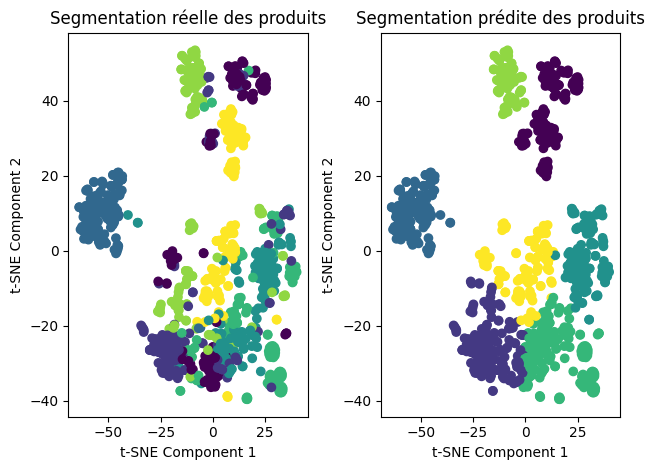

In [16]:
plt.subplot(1, 2, 1)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation réelle des produits')

plt.subplot(1, 2, 2)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=cls_labels_transform, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation prédite des produits')

plt.tight_layout()
plt.show()

Il convient en plus d'une analyse graphique de réaliser une analyse technique de la segmentation réalisé par le modèle k-means. Pour cela nous utilisons l'[ARI](), (Adjusted Rand Index), une mesure de similarité entre deux ensembles d'éléments, souvent utilisée pour évaluer la qualité d'une partition dans le contexte de l'analyse de clustering. Cette metric mesure la similarité entre les regroupements produits par un algorithme de clustering et les regroupements réels ou attendus, en prenant en compte le hasard.

In [17]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, kmeans.labels_),4)
ARI

0.3828